In [ ]:
# !git clone https://github.com/Elroborn/Learn-Convolutional-Neural-Network-for-Face-Anti-Spoofing_pytorch.git
# %cd Learn-Convolutional-Neural-Network-for-Face-Anti-Spoofing_pytorch

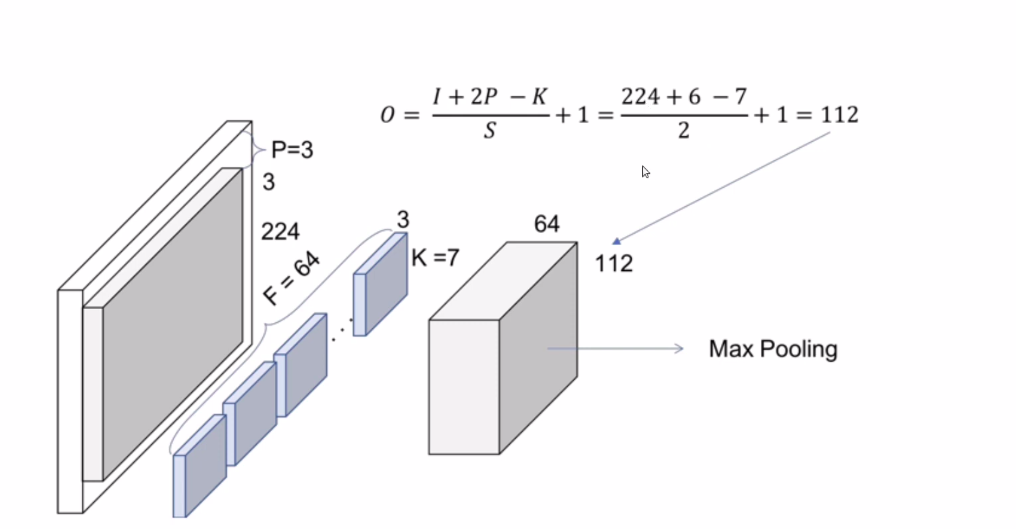

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
        transforms.RandomRotation(10),      
        transforms.RandomHorizontalFlip(),  
        transforms.Resize(224),             
        transforms.CenterCrop(128),
        transforms.ToTensor()
])

class Process_Data():
    def __init__(self, root, transform = None):
        self.data = datasets.ImageFolder(root, transform = transform)
        self.classes = self.data.classes
        self.num_classes = len(self.classes)
        
    def __getitem__(self, index):
        img, label = self.data[index]
        one_hot_label = F.one_hot(torch.tensor(label), num_classes = self.num_classes)
        
        return img, one_hot_label
    
    def __len__(self):
        return len(self.data)
    
x_train = Process_Data( root = "/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training", transform = transform)
x_val = Process_Data(root = "/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation/", transform = transform)

In [3]:
class_name = x_train.classes
print("Tổng class: ",len(class_name))
print("Tên các loại: ",class_name)

params = {'batch_size': 32, "shuffle": True, "num_workers": 8,
            "pin_memory": True} if device.type == 'cuda' else{}

train_loader = DataLoader(x_train, **params)
val_loader = DataLoader(x_val, **params)

Tổng class:  2
Tên các loại:  ['real', 'spoof']


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super(block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
   
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)

        
        if self.identity_downsample is not None: #  Lớp này cho lần chạy đầu để kích thước khớp với X
            identity = self.identity_downsample(identity)
            
        x += identity
        x = self.relu(x)
        return x
    
    
class ResNet(nn.Module):
    def __init__(self, block, layers: list, image_channels: int, num_classes:int ):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size = 7, stride = 2, padding = 3, bias = False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x
        
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsaple = None
        layers = []
        
    
        identity_downsample = nn.Sequential(
            nn.Conv2d(
                self.in_channels,
                intermediate_channels ,
                kernel_size = 1,
                stride = stride,
                bias = False,
            ),
            nn.BatchNorm2d(intermediate_channels )
        )
        layers.append(
            block(self.in_channels,intermediate_channels,identity_downsample, stride)
        )
        
        self.in_channels = intermediate_channels
        
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))
        
        return nn.Sequential(*layers)
            
def ResNet18(img_channel=3, num_classes=2):
    return ResNet(block, [2, 2, 2, 2], img_channel, num_classes)

In [25]:
if device.type == 'cuda':
    net = ResNet18(img_channel=3, num_classes=2).to(device)
if torch.cuda.device_count()>1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(net)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)

Using 2 GPUs!


In [26]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+----------------------------------------------+------------+
|                   Modules                    | Parameters |
+----------------------------------------------+------------+
|             module.conv1.weight              |    9408    |
|              module.bn1.weight               |     64     |
|               module.bn1.bias                |     64     |
|         module.layer1.0.conv1.weight         |   36864    |
|          module.layer1.0.bn1.weight          |     64     |
|           module.layer1.0.bn1.bias           |     64     |
|         module.layer1.0.conv2.weight         |   36864    |
|          module.layer1.0.bn2.weight          |     64     |
|           module.layer1.0.bn2.bias           |     64     |
| module.layer1.0.identity_downsample.0.weight |    4096    |
| module.layer1.0.identity_downsample.1.weight |     64     |
|  module.layer1.0.identity_downsample.1.bias  |     64     |
|         module.layer1.1.conv1.weight         |   36864    |
|       

11181762

In [ ]:
n_total_steps = len(train_loader)

run_loss = 0.0
run_acc = 0.0
epochs = 1
for epoch in range(epochs):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.reshape(-1,3,128,128).to(device)
        labels = labels.to(device)
        _, labels = torch.max(labels.data, 1)

        outputs = model(images)

        loss = F.cross_entropy(outputs,labels)
        
        run_loss =loss.item() #for tensorboard
        _,pred = torch.max(outputs.data, 1)
        run_acc += (pred==labels).sum().item()#for tensorboard
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 3 == 0:
            
            ############################## Check validation_data ###################################
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(2)]
                n_class_samples = [0 for i in range(2)]
                
                for images_val, labels_val in val_loader:
                    images_val = images_val.reshape(-1,3,128,128).to(device)
                    labels_val = labels_val.to(device)
                    _, labels_val = torch.max(labels_val.data, 1)
                    
                    output_val = model(images_val)
                    _, predict_val = torch.max(output_val.data, 1)
                    n_samples += labels_val.size(0)
                    n_correct += (predict_val == labels_val).sum().item()
                    loss_val = F.mse_loss(labels_val.float(),predict_val.float())
                    for i in range(26):
                        label_val = labels_val[i]
                        pred_val = predict_val[i]
                        if label_val == pred_val:
                            n_class_correct[label_val] += 1
                            
                        n_class_samples[label_val] += 1
                        
                acc_val = n_correct/(n_samples)
                acc_val_total = run_acc/((3-1)*128+pred.size(0))

                
                print(f'Epoch[{epoch+1}/{epochs}]:  Loss_Train: {(run_loss/3):.2f}, Acc_Train: {acc_val_total:.2f} , Loss_Val: {loss_val:.2f} , Acc_Val: {acc_val:.2f}')
            

In [ ]:
def model_summary(model):
  print("model_summary")
  print()
  print("Layer_name"+"\t"*7+"Number of Parameters")
  print("="*100)
  model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
  layer_name = [child for child in model.children()]
  j = 0
  total_params = 0
  print("\t"*10)
  for i in layer_name:
    print()
    param = 0
    try:
      bias = (i.bias is not None)
    except:
      bias = False  
    if not bias:
      param =model_parameters[j].numel()+model_parameters[j+1].numel()
      j = j+2
    else:
      param =model_parameters[j].numel()
      j = j+1
    print(str(i)+"\t"*3+str(param))
    total_params+=param
  print("="*100)
  print(f"Total Params:{total_params}")       

model_summary(net)